In [ ]:
from pathlib import Path

ROOT = Path(globals()['__vsc_ipynb_file__']).parent.parent
print(ROOT)

import sys
sys.path.append(str(ROOT))

In [5]:
from src.experiment import Experiment
from model_validator.validator import is_feasible, is_feasible_with_objective

from qiskit import qpy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

#### Functions

In [3]:
def compare_initializations_to_dataframe(base_path: str, penalty_labels: list, runs: int = 10):
    """
    Compare penalties, plot results, and return a DataFrame with mean, std, and penalty labels.

    Args:
        base_path (str): Directory where all penalty folders are located.
        penalty_labels (list): List of folder names for each penalty value.
        runs (int): Number of experiment runs.

    Returns:
        pd.DataFrame: Long-form DataFrame with columns: 'iteration', 'mean', 'std', 'penalty'
    """
    
    records = []

    kkd = 0
    for penalty in penalty_labels:
        folder = f"{base_path}/{penalty}"
        print(folder)

        num_iters_min = 1000
        num_iters = 0
        for run_id in range(0, runs):
            # print(f"{folder}/exp{run_id}.pkl")
            ds = Experiment.read_experiment(f"{folder}/exp{run_id}.pkl")
            if len(ds.step3_iter_best_fx) > num_iters: 
                num_iters = len(ds.step3_iter_best_fx)
            if len(ds.step3_iter_best_fx) < num_iters_min: 
                num_iters_min = len(ds.step3_iter_best_fx)

        data = np.zeros((num_iters, runs))

        idd = 0
        avr_time = 0
        best_fx = 100
        for run_id in range(0, runs):
            ds = Experiment.read_experiment(f"{folder}/exp{run_id}.pkl")
            avr_time += ds.step3_time
            if ds.step3_result_best_fx < best_fx:
                best_fx = ds.step3_result_best_fx
            if len(ds.step3_iter_best_fx) == num_iters:
                # print("TRUE")
                # print(f"iters: {num_iters}, iters_real: {len(ds.step3_iter_best_fx)}", num_iters - len(ds.step3_iter_best_fx))
                # print(f"{penalty} run {run_id} too short. Skipping.")
                # data[len(ds.step3_iter_best_fx):,run_id] = ds.refvalue * np.ones(num_iters - len(ds.step3_iter_best_fx))

                data[:, idd] = ds.step3_iter_best_fx
                idd += 1
        
        refvalue = ds.refvalue

        # mean_fx = np.mean(data[:num_iters_min,:idd], axis=1)
        # # print(np.mean(mean_fx))
        # std_fx = np.std(data[:num_iters_min,:idd], axis=1)
        
        mean_fx = np.mean(data[:,:idd], axis=1)
        # print(np.mean(mean_fx))
        std_fx = np.std(data[:,:idd], axis=1)

        best_mean_fx = np.min(mean_fx)
        best_index = np.argmin(mean_fx)
        print(f'idd: {idd}, best fx: {best_fx}, best mean fx: {best_mean_fx} +- std {std_fx[best_index]}, avr time step3: {np.mean(avr_time)}')

        # Add records for DataFrame
        print(num_iters,num_iters_min)
        records.append({
            "iteration": kkd,
            "mean": mean_fx,
            "std": std_fx,
            "penalty": penalty,
            "refvalue": refvalue,
            "num_iters": num_iters,
            "num_iters_min": num_iters_min,
            "avr_time": np.mean(avr_time)
            })
        
        kkd += 1

    return records

def hamming_similarity(a, b):
    return sum(i == j for i, j in zip(a, b)) / len(a)


def hamming_data(runs: int, penalties, num_inits):
    data_step3 = []

    for jd in penalties:
        data_step3_exp = []
        for id in range(0, runs):
            # print(id)
            # print(id, f'1/31bonds/Penalty2p5_TwoLocal2rep_piby3_AerSimulator_0p1/exp{id}.pkl')
            ds = Experiment.read_experiment(f'1/31bonds/{jd}/exp{id}.pkl')

            # print(ds.step3_result_best_x)
            data_step3_exp.append({
                        "iter": id,
                        "best_x": ds.step3_result_best_x,
                        "best_fx": ds.step3_result_best_fx,
                        "refx": ds.refx,
                        "refvalue": ds.refvalue
                        })
        data_step3.append(data_step3_exp)


    hamming = np.zeros((runs, num_inits))
    for jd in range(num_inits):
        for id in range(runs):
            # print(jd, id)
            refx = data_step3[jd][id]['refx']
            x = data_step3[jd][id]['best_x']
            refx_norm = refx / np.linalg.norm(refx)
            x_norm = x / np.linalg.norm(x)
            hamming[id,jd] = hamming_similarity(refx_norm,x_norm)
    
    return hamming


#### TwoLocal, rep=2, alpha=0.1, bilinear, penalty=1.1, random initialization

##### plot objective vs iteration

In [4]:
penalties = [
    "Penalty1p1_TwoLocal2rep_piby3_AerSimulator_0p1",
    "RandomInit1_TwoLocal2rep_piby3_AerSimulator_0p1",
    "RandomInit2_TwoLocal2rep_piby3_AerSimulator_0p1",
    "RandomInit3_TwoLocal2rep_piby3_AerSimulator_0p1"
]

data_penalty_TwoLocal = compare_initializations_to_dataframe("1/31bonds", penalties, 10)

1/31bonds/Penalty1p1_TwoLocal2rep_piby3_AerSimulator_0p1


idd: 9, best fx: 40.293929358426794, best mean fx: 40.86460230685636 +- std 0.4224100934366024, avr time step3: 7786.317231178284
373 49
1/31bonds/RandomInit1_TwoLocal2rep_piby3_AerSimulator_0p1
idd: 9, best fx: 40.293929358426794, best mean fx: 42.157688402154626 +- std 2.1133627696393114, avr time step3: 5536.371064662933
373 50
1/31bonds/RandomInit2_TwoLocal2rep_piby3_AerSimulator_0p1
idd: 9, best fx: 40.293929358426794, best mean fx: 40.944432078841245 +- std 0.7049494466873082, avr time step3: 5479.316941976547
373 42
1/31bonds/RandomInit3_TwoLocal2rep_piby3_AerSimulator_0p1
idd: 9, best fx: 40.293929358426794, best mean fx: 41.2846489445582 +- std 0.7252505359587301, avr time step3: 5931.8629603385925
373 318


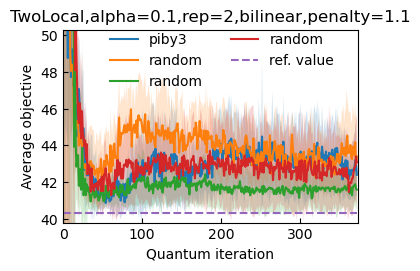

In [18]:
plt.figure(figsize=(3.8, 2.5))
fig_labels = ['piby3', 'random', 'random', 'random']
for id in range(4):
    data = data_penalty_TwoLocal[id]
    # print(data['num_iters'], len(data['mean']))
    sns.lineplot(x=range(data['num_iters']), y=data['mean'], label=f"{fig_labels[id]}")
    plt.fill_between(range(data['num_iters']), data['mean'] - data['std'], data['mean'] + data['std'], alpha=0.2)
plt.plot([0, data['num_iters'] - 1], [data['refvalue'], data['refvalue']], '--', label="ref. value")
plt.ylim(data['refvalue']-0.5, data['refvalue'] + 10)
plt.xlim(0,data["num_iters"])
plt.tick_params(axis='both', direction='in')
plt.xlabel("Quantum iteration")
plt.ylabel("Average objective")
plt.title("TwoLocal,alpha=0.1,rep=2,bilinear,penalty=1.1")
plt.legend(
    ncol=2,                # two columns
    frameon=False,         # no border frame
    loc='upper center',    # position (customize as needed)
    bbox_to_anchor=(0.54, 1.05)
)
plt.savefig("imgs/INITIALIZATIONS_TwoLocal_rep2_alpha0p1_bilinear.png", dpi=300, bbox_inches='tight')

##### hamming

In [11]:
runs = 10
num_inits = 4

hamming = hamming_data(runs, penalties, num_inits)
hamming, np.mean(hamming, axis=0)

(array([[0.74193548, 0.74193548, 0.19354839, 0.67741935],
        [0.74193548, 0.67741935, 0.80645161, 0.67741935],
        [1.        , 0.80645161, 0.61290323, 0.61290323],
        [0.80645161, 0.67741935, 0.80645161, 0.80645161],
        [0.80645161, 0.80645161, 1.        , 1.        ],
        [0.87096774, 0.87096774, 0.61290323, 0.87096774],
        [0.87096774, 0.67741935, 0.87096774, 0.80645161],
        [0.74193548, 0.87096774, 0.61290323, 0.61290323],
        [0.61290323, 1.        , 0.61290323, 0.80645161],
        [0.80645161, 0.74193548, 0.80645161, 0.61290323]]),
 array([0.8       , 0.78709677, 0.69354839, 0.7483871 ]))

##### ansatz characteristics

In [12]:
with open(f'{ROOT}/data/1/31bonds/Penalty1p1_TwoLocal2rep_piby3_AerSimulator_0p1/isa_ansatz.qpy', 'rb') as fd:
    isa_ansatz = qpy.load(fd)[0]
print(id)
print('depth:', isa_ansatz.depth(), '    2q-depth: ', isa_ansatz.depth(lambda x:x.operation.num_qubits==2), '      num params: ', isa_ansatz.num_parameters)
print(f"num-q/width: {isa_ansatz.num_qubits}, \ncount ops: {isa_ansatz.count_ops()}\n")

3
depth: 8     2q-depth:  4       num params:  93
num-q/width: 31, 
count ops: OrderedDict([('ry', 93), ('cz', 60), ('measure', 31), ('barrier', 1)])



#### Is the solution feasible?

In [11]:
runs = 10
feasible = np.zeros((len(penalties),runs))


for id in range(len(penalties)):
    for run_id in range(10):
        ds = Experiment.read_experiment(f"/1/31bonds/{penalties[id]}/exp{run_id}.pkl")
        feasible[id,run_id] = is_feasible(f'../data/1/31bonds/docplex-bin-avgonly-nocplexvars.lp',ds.step3_result_best_x)

In [12]:
feasible

array([[1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 0., 0., 1., 0.]])

In [13]:
np.sum(feasible == True, axis=1)/runs

array([0.8, 0.7, 0.3, 0.5])

#### bfcd, rep2, alpha=0.1, bilinear, peanlty = 1.1, random initialization

##### plot objective vs iteration

In [14]:
penalties = [
    "Penalty1p1_bfcd2rep_piby3_AerSimulator_0p1",
    "RandomInit1_bfcd2rep_piby3_AerSimulator_0p1",
    "RandomInit2_bfcd2rep_piby3_AerSimulator_0p1",
    "RandomInit3_bfcd2rep_piby3_AerSimulator_0p1"
]

data_penalty_bfcd = compare_initializations_to_dataframe("1/31bonds", penalties, 10)

1/31bonds/Penalty1p1_bfcd2rep_piby3_AerSimulator_0p1


idd: 7, best fx: 40.293929358426794, best mean fx: 40.74714726298004 +- std 0.2859209360065089, avr time step3: 15330.562261343002
729 50
1/31bonds/RandomInit1_bfcd2rep_piby3_AerSimulator_0p1
idd: 7, best fx: 40.293929358426794, best mean fx: 40.7740697009012 +- std 0.2372359407775309, avr time step3: 10879.18658208847
729 61
1/31bonds/RandomInit2_bfcd2rep_piby3_AerSimulator_0p1
idd: 9, best fx: 40.293929358426794, best mean fx: 40.68240728403633 +- std 0.2564298862157708, avr time step3: 11885.634877204895
729 147
1/31bonds/RandomInit3_bfcd2rep_piby3_AerSimulator_0p1
idd: 10, best fx: 40.30142534743054, best mean fx: 41.27306162850904 +- std 1.213301715835184, avr time step3: 12886.74793601036
729 729


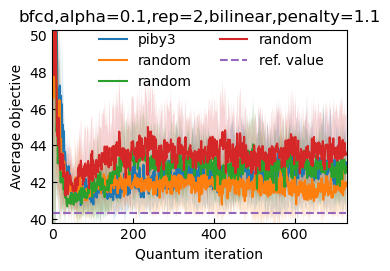

In [17]:
plt.figure(figsize=(3.8, 2.5))
fig_labels = ['piby3', 'random', 'random', 'random']
for id in range(4):
    data = data_penalty_bfcd[id]
    # print(data['num_iters'], len(data['mean']))
    sns.lineplot(x=range(data['num_iters']), y=data['mean'], label=f"{fig_labels[id]}")
    plt.fill_between(range(data['num_iters']), data['mean'] - data['std'], data['mean'] + data['std'], alpha=0.2)
plt.plot([0, data['num_iters'] - 1], [data['refvalue'], data['refvalue']], '--', label="ref. value")
plt.ylim(data['refvalue']-0.5, data['refvalue'] + 10)
plt.xlim(0,data["num_iters"])
plt.tick_params(axis='both', direction='in')
plt.xlabel("Quantum iteration")
plt.ylabel("Average objective")
plt.title("bfcd,alpha=0.1,rep=2,bilinear,penalty=1.1")
plt.legend(
    ncol=2,                # two columns
    frameon=False,         # no border frame
    loc='upper center',    # position (customize as needed)
    bbox_to_anchor=(0.54, 1.05)
)
plt.savefig("imgs/INITIALIZATIONS_bfcd_rep2_alpha0p1_bilinear.png", dpi=300, bbox_inches='tight')

##### hamming

In [20]:
runs = 10
num_inits = 4

hamming = hamming_data(runs, penalties, num_inits)
hamming, np.mean(hamming, axis=0)

(array([[0.80645161, 1.        , 0.80645161, 0.61290323],
        [0.87096774, 1.        , 1.        , 0.67741935],
        [0.74193548, 0.74193548, 0.67741935, 0.87096774],
        [1.        , 1.        , 0.67741935, 0.74193548],
        [0.87096774, 0.87096774, 0.80645161, 0.67741935],
        [0.80645161, 0.74193548, 0.80645161, 0.87096774],
        [0.80645161, 0.74193548, 0.61290323, 0.74193548],
        [0.74193548, 0.74193548, 0.80645161, 0.67741935],
        [1.        , 0.87096774, 0.74193548, 0.87096774],
        [1.        , 0.80645161, 0.67741935, 0.87096774]]),
 array([0.86451613, 0.8516129 , 0.76129032, 0.76129032]))

##### ansatz characteristics

In [21]:

with open(f'{ROOT}/data/1/31bonds/Penalty1p1_bfcd2rep_piby3_AerSimulator_0p1/isa_ansatz.qpy', 'rb') as fd:
    isa_ansatz = qpy.load(fd)[0]
print(id)
print('depth:', isa_ansatz.depth(), '    2q-depth: ', isa_ansatz.depth(lambda x:x.operation.num_qubits==2), '      num params: ', isa_ansatz.num_parameters)
print(f"num-q/width: {isa_ansatz.num_qubits}, \ncount ops: {isa_ansatz.count_ops()}\n")

3
depth: 19     2q-depth:  8       num params:  182
num-q/width: 31, 
count ops: OrderedDict([('rx', 180), ('rzz', 120), ('ry', 62), ('measure', 31), ('barrier', 1)])



#### Is the solution feasible?

In [15]:
runs = 10
feasible = np.zeros((len(penalties),runs))


for id in range(len(penalties)):
    for run_id in range(10):
        ds = Experiment.read_experiment(f"/1/31bonds/{penalties[id]}/exp{run_id}.pkl")
        feasible[id,run_id] = is_feasible(f'../data/1/31bonds/docplex-bin-avgonly-nocplexvars.lp',ds.step3_result_best_x)

In [16]:
feasible

array([[1., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 1., 0., 1.]])

In [18]:
np.sum(feasible==True, axis=1)/runs

array([0.7, 0.4, 0.6, 0.4])